# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

Описание проекта.

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

План работы.
1. Откройте файл с данными и изучите его. Путь к файлу: /datasets/users_behavior.csv. Скачать датасет
2. Разделите исходные данные на обучающую, валидационную и тестовую выборки.
3. Исследуйте качество разных моделей, меняя гиперпараметры. Кратко напишите выводы исследования.
4. Проверьте качество модели на тестовой выборке.
5. Дополнительное задание: проверьте модели на вменяемость.

Описание данных.

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
- сalls — количество звонков,
- minutes — суммарная длительность звонков в минутах,
- messages — количество sms-сообщений,
- mb_used — израсходованный интернет-трафик в Мб,
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Откройте и изучите файл

**1.1. Импортировать библиотеки.**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier # импорт библиотеки 'Дерево решений'
from sklearn.ensemble import RandomForestClassifier # импорт библиотеки 'Случайный лес'
from sklearn.linear_model import LogisticRegression # импорт библиотеки 'Логистическая регрессия'
from sklearn.metrics import accuracy_score # импорт метрики 'accuracy' (точность)
from sklearn import tree
from sklearn.dummy import DummyClassifier
from matplotlib.pyplot import figure
from tqdm import tqdm

1.1.1 Считайть данные из csv-файла в датафрейм и сохранить в переменную `df`

In [2]:
# прочитаем csv-файл
try:
    df = pd.read_csv('/datasets/users_behavior.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/users_behavior.csv')

**1.2 Изучить общую информацию о полученном датафрейме.**

In [3]:
df.head(20) # вывод первых 20 строчек датафрейма df на экран.

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


In [4]:
df.info() #Вывод основной информации о датафрейме с помощью метода info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Вывод. Предобработка данных не понадобится, т.к. была выполнена ранее.
Перед нами задача бинарной классификации. Качественный целевой признак - выбор тарифа («Ультра» — 1, «Смарт» — 0).

**1.3 Проверка сбалансированности**

In [5]:
df['is_ultra'].value_counts(normalize = 1)

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

## Разбейте данные на выборки

**2.1. Разделим на признаки и целевой признак.**

In [6]:
#разделим на признаки и целевой признак
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']

**2.2. Разделим исходные данные на обучающую (60%), валидационную (20%) и тестовую (20%) выборки.**

2.2.1 Произведём двухэтапое деление. 
Первый этап -  деление на двухкомпонентную выборку:  обучающая (60%) и валидационная + тестовая (40%).
Второй этап  - деление на двухкомпонентную выборку уже разделенной  валидационной + тестовой выборки: валидационная (80%) и тестовая (20%).
Итого получилось 3 выборки: обучающая (60%), валидационная (20%) и тестовая (20%).

In [7]:
# обучающая и валидационная + тестовая выборки, 60% и 40%
features_train, features_val_test, target_train, target_val_test = train_test_split(features, 
                                                                          target,
                                                                          train_size=0.6, 
                                                                          random_state=12345, 
                                                                          stratify=target)
# валидационная и тестовая выборки, 20% и 20%
features_valid, features_test, target_valid, target_test = train_test_split(features_val_test,
                                                                            target_val_test, 
                                                                            test_size=0.2, 
                                                                            random_state=12345, 
                                                                            stratify=target_val_test)

Получились следующие выборки.

Обучающая (60%):
features_train,a
target_train

Валидационная (20%):
features_valid, 
target_valid

Тестовая (20%):
features_test, 
target_test

2.2.2 Проверим корректность разбиения.

In [8]:
features_train.shape, target_train.shape, features_valid.shape, target_valid.shape, features_test.shape, target_test.shape

((1928, 4), (1928,), (1028, 4), (1028,), (258, 4), (258,))

## Исследуйте модели

**3.1. Исследуем качество разных моделей: решающее дерево, случайный лес, логистическая регрессия.**

3.1.1 Эксперимент с решающим деревом. Глубина дерева от 1 до 5.

In [9]:
arr_valid = []
arr_train = []
# цикл для max_depth от 1 до 5
for depth in range(1, 20):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    predictions_train = model.predict(features_train)
    print("Глубина", depth, end=' ')
    print(accuracy_score(target_valid, predictions_valid)) 
    valid_accuracy_score = accuracy_score(target_valid, predictions_valid)
    arr_valid.append(valid_accuracy_score)  
    train_accuracy_score = accuracy_score(target_train, predictions_train)
    arr_train.append(train_accuracy_score) 


Глубина 1 0.7324902723735408
Глубина 2 0.7714007782101168
Глубина 3 0.7908560311284046
Глубина 4 0.7607003891050583
Глубина 5 0.7957198443579766
Глубина 6 0.7821011673151751
Глубина 7 0.7908560311284046
Глубина 8 0.791828793774319
Глубина 9 0.7850194552529183
Глубина 10 0.7830739299610895
Глубина 11 0.769455252918288
Глубина 12 0.7587548638132295
Глубина 13 0.7470817120622568
Глубина 14 0.7490272373540856
Глубина 15 0.7470817120622568
Глубина 16 0.7363813229571985
Глубина 17 0.7237354085603113
Глубина 18 0.7169260700389105
Глубина 19 0.7110894941634242


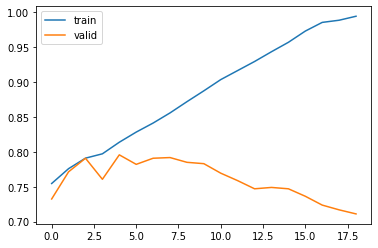

In [10]:
plt.plot(arr_train, label='train')
plt.plot(arr_valid, label='valid')
plt.legend()
plt.show()

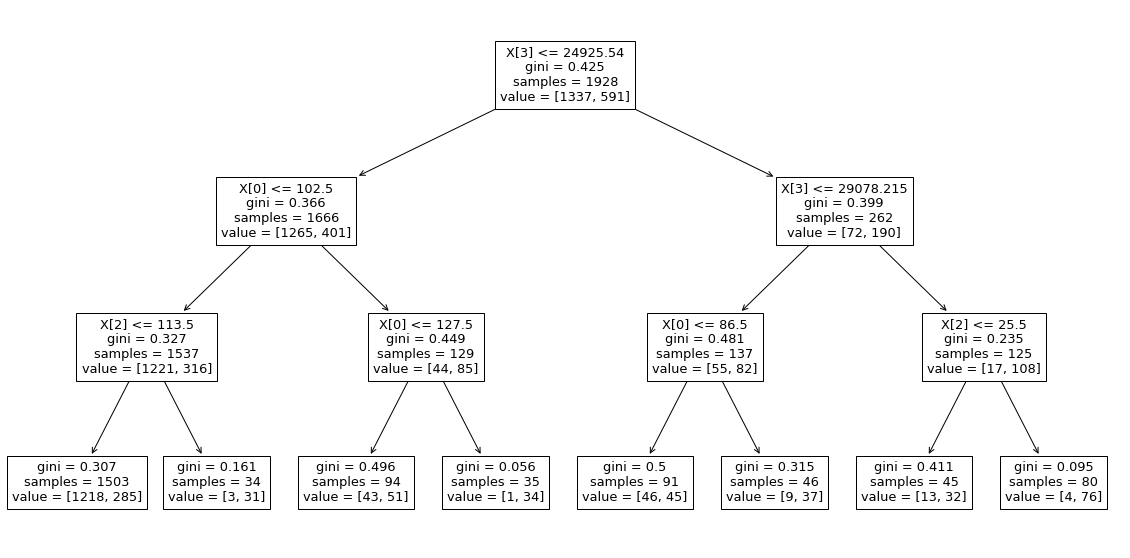

In [11]:
model_tree = DecisionTreeClassifier(random_state=12345, max_depth=3)
model_tree.fit(features_train, target_train)
plt.figure(figsize=(20, 10))
tree.plot_tree(model_tree)
plt.show()

3.1.2 Эксперимент со случайным лесом. Проверим модель с глубиной от 1 до 20. Покажем лучший результат.

In [13]:
#%%time
for i in tqdm(range(2)):
    best_model = None
    best_result = 0
    best_est = 0
    best_depth = 0
    for est in range(1, 21):
        for depth in range (1, 11):
            model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth) # инициализировать модель RandomForestRegressor с параметрами random_state=12345, n_estimators=est и max_depth=depth
            model.fit(features_train, target_train) # обучить модель на тренировочной выборке
            predictions_valid = model.predict(features_valid) # получить предсказания модели на валидационной выборке
            result = model.score(features_valid, target_valid) # посчитайте качество модели на валидационной выборке
        #result = mean_squared_error(target_valid, predictions_valid)**0.5 # посчитайте значение метрики rmse на валидационной выборке
        if result > best_result:
            best_model = model # сохраните наилучшую модель
            best_result = result #  сохраните наилучшее значение метрики accuracy на валидационных данных
            best_est = est
            best_depth = depth

"Accuracy наилучшей модели на валидационной выборке:", best_result, "Количество деревьев:", best_est, "Максимальная глубина:", depth

100%|██████████| 2/2 [00:15<00:00,  7.97s/it]


('Accuracy наилучшей модели на валидационной выборке:',
 0.811284046692607,
 'Количество деревьев:',
 20,
 'Максимальная глубина:',
 10)

3.1.3 Эксперимент с логистической регрессией

Исследование логистической регрессии алгоритмом 'lbfgs'

In [14]:
model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000) 
model.fit(features_train, target_train) 
model.predict(features_valid) 
result = model.score(features_valid, target_valid) 
"Accuracy лучшей модели:", result

('Accuracy лучшей модели:', 0.7383268482490273)

Исследование логистической регрессии алгоритмом 'liblinear'

In [15]:
model = LogisticRegression(random_state=12345, solver='liblinear', max_iter=1000) 
model.fit(features_train, target_train) 
model.predict(features_valid) 
result = model.score(features_valid, target_valid) 
"Accuracy лучшей модели:", result

('Accuracy лучшей модели:', 0.7130350194552529)

Исследование логистической регрессии алгоритмом 'newton-cg'

In [16]:
model = LogisticRegression(random_state=12345, solver='newton-cg', max_iter=500) 
model.fit(features_train, target_train) 
model.predict(features_valid) 
result = model.score(features_valid, target_valid) 
"Accuracy лучшей модели:", result

('Accuracy лучшей модели:', 0.7383268482490273)

Алгоритмы логистической регрессии показали самые слабые результаты. Дерево решений и случайный лес показали близкий результат. Самую высокую точность показал Случайный лес.

## Проверьте модель на тестовой выборке

**4.1 Выполним проверку модели 'случайный лес' на тестовой выборке.**

In [17]:
result = best_model.score(features_test, target_test) # посчитить качество модели на тестовой выборке
"Accuracy наилучшей модели на валидационной выборке:", result

('Accuracy наилучшей модели на валидационной выборке:', 0.8062015503875969)

Проверили модель 'случайный лес' на тестовой выборке.
Доля правильных ответов не менее 0.8, что соответствует поставленной задаче.

## Проверьте модели на адекватность

Точность модели может быть расчитана по формуле:
accuracy = количество объектов/количество правильных ответов.
Рассмотрим отдельно ответы «1» (тариф 'Ультра') и «0» (тариф 'Смарт'):

accuracy = (количество ответов 1) ⋅ (доля ответов 1) + (количество ответов 0) ⋅ (доля ответов 0) / количество ответов всего 

5.1.1 Посчитаем количество значений "1".

In [18]:
count_one = df.loc[df['is_ultra'] == 1, 'is_ultra'].count()

5.1.2 Посчитаем количество значений "0".

In [19]:
count_zero = df.loc[df['is_ultra'] == 0, 'is_ultra'].count()

5.1.3 Общее кол-во пользователей двух тарифов.

In [20]:
count_sum = df['is_ultra'].value_counts().sum()

In [21]:
# count_one/count_sum - доля '1', 1 - count_one/count_sum - доля '0'
accuracy = (count_one * (count_one/count_sum)  + count_zero * (1 - count_one/count_sum))/count_sum
accuracy

0.5749064163513006

Случайные ответы имеют результат - 0,575.
Финальная модель, со значением 0,8, показывает результаты лучше, чем случайные ответы — модель можно считать адекватной.

Вывод. 
- Первоначальный датасет имел выраженный дисбаланс (70% ответов целевого признака были нулевые, 30% ровнялись 1).
Для корректности проводимого обучения сохранили сохранили изначальное распределение таргетов во всех новых датасетах
с помощью аргумент stratify.
- Было проведено исследуем качество разных моделей: решающее дерево, случайный лес, логистическая регрессии. Улучшение модели происходило путем цикла выбора гиперпараметров.
- Лучший результат показал  - случайный лес (RandomForestClassifier).
- Финальные параметры выбранной модели RandomForestClassifier(random_state=12345, n_estimators=20, max_depth=10). Точность модели на тестовой выборке - 0,8.
- Модель RandomForestClassifier прошла проверку на адекватность в сравнении с константной моделью: score константой модели: 0,693.

In [22]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(features_train, target_train)
dummy_clf.predict(features_train)
dummy_clf.score(features_train, target_train)

0.6934647302904564